# Определение рыночной стоимости автомобиля

В сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. Перед нами поставлена задача построить алгоритм, который будет определять стоимость автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей.

В рамках проекта важно поднять качество модели, при этом не жертвуя временем обучения и временем предсказания модели. Для оценки качества моделей будем применять метрику RMSE, значение которой должно быть меньше 2500.

### Извлечем и проведем первичный анализ представленных данных

### Устанавливаем и импортируем библиотеки, которые будут использоваться в проекте

In [1]:
#!pip install lightgbm
#!pip install phik

In [2]:
import copy
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pcl
import phik
import pylab as pl
import random as r
import seaborn as sns
import statistics as st
import time
from datetime import datetime
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy.stats import (
    shapiro,
    normaltest
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    recall_score,
    mean_squared_error
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler)
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant 

In [3]:
print("Версия LightGBM: ", lgb.__version__)
print("Версия phik: ", phik.__version__)

Версия LightGBM:  3.3.3
Версия phik:  0.12.2


### Извлечем данные

In [4]:
data_pth1 = 'C:\\Dataset\\autos.csv'
data_pth2 = '/datasets/autos.csv'

if os.path.exists(data_pth1):
    df = pd.read_csv(data_pth1)
elif os.path.exists(data_pth2):
    df = pd.read_csv(data_pth2)
else:
    print("Проверьте путь к датасету")

pd.set_option('display.max_columns', 90)

### Проведем первичный анализ данных и их предобработку

In [5]:
df.info()
# Многие данные представлены в int64. Вряд ли в контексте километража или цены это целесообразно. Проверим.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Многие данные представлены в int64. Вряд ли в контексте километража или цены это целесообразно. Проверим.

In [6]:
def heat_map(df, title):
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    codes_plot = sns.heatmap(df, cmap="BrBG", annot=True)
    plt.title(title)
    plt.show()

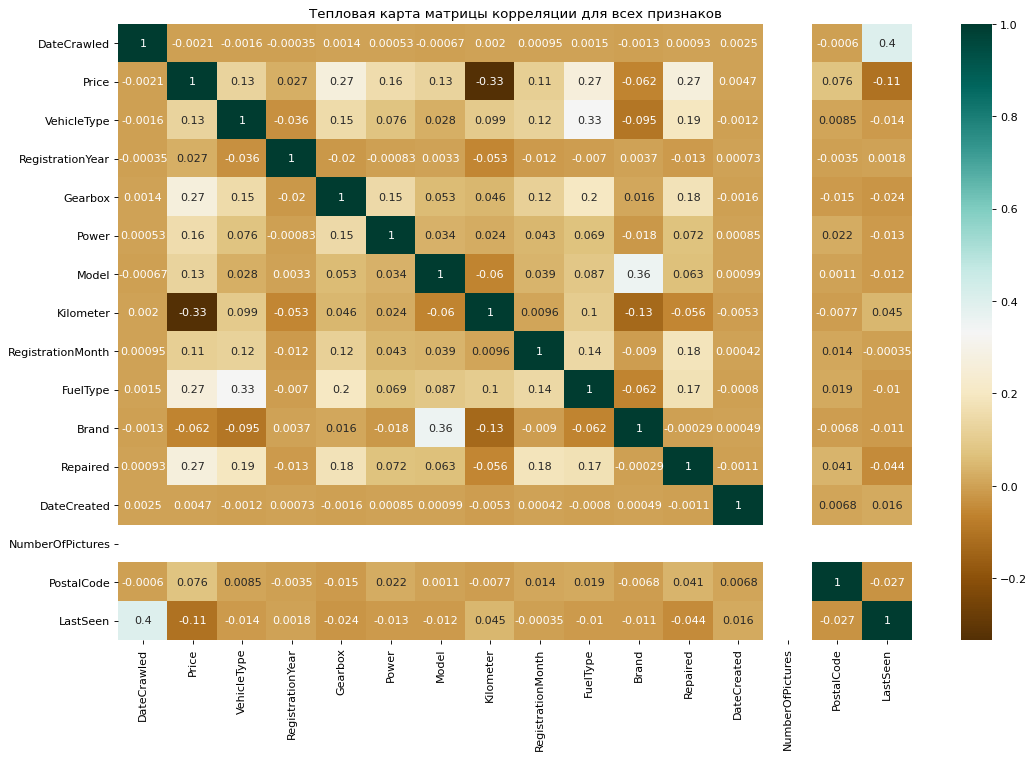

In [7]:
column = df.select_dtypes(include=['object']).columns
codes = copy.deepcopy(df)
for i in column:
    codes[i], uniques = pd.factorize(codes[i])
    
heat_map(codes.corr(), "Тепловая карта матрицы корреляции для всех признаков")

# Высокой корреляции между признаками не наблюдается. Слабая корреляция наблюдается между моделью авто и брэндом, 
# а также между типом кузова и видом топлива. Похоже, что данных об изображениях нет.

Высокой корреляции между признаками не наблюдается. Слабая корреляция наблюдается между моделью авто (Model) и брэндом(Brand) = **0.36**, а также между типом кузова( VehicleType) и видом топлива(FuelType) = **0.33**. Похоже, что данных об изображениях(NumberOfPictures) нет.

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Значения в столбцах с int64 не превышают 150тыс. Можно оптимизировать объем данных

### Оптимизируем объем данных

In [9]:
df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']] \
= df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']]\
.astype('int32')

In [10]:
df.info() 
# уменьшили объем данных почти на 10мб, около 23%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int32 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int32 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int32 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int32 
 8   RegistrationMonth  354369 non-null  int32 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int32 
 14  PostalCode         354369 non-null  int32 
 15  LastSeen           354369 non-null  object
dtypes: int32(7), object(

Уменьшили объем данных почти на 10мб, около 23%.

### Удаляем неинформативные признаки и ставим заглушку в пропусках о ремонте авто

In [11]:
print(df[df['Price'] < 1]['Price'].count().sum())
# Бесплатные авто предлагаются в 3% объявлений. Подозрительно. Сначала обработаем другие признаки.

10772


Бесплатные авто предлагаются в 3% объявлений. Подозрительно. В любом случае сначала обработаем другие признаки.

**DateCrawled** — дата скачивания анкеты из базы

**PostalCode** — почтовый индекс владельца анкеты (пользователя)

**LastSeen** — дата последней активности пользователя


Эти данные касаются владельца автомобиля, соответственно на рыночную цену автомобиля они влиять не должны. Удалим их.


**RegistrationMonth** — месяц регистрации автомобиля. Поскольку в год может выходить несколько моделей одной и той же марки, то возможно эти данные могут оказаться полезными наравне с годом регистрации автомобиля.


**DateCreated** — дата создания анкеты поможет нам вычислить возраст автомобиля, пока оставляем.

In [12]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [13]:
df['DateCrawled'].max()
# Все анкеты были скачаны до 8 апреля 2016 года

'2016-04-07 14:36:58'

Все анкеты были скачаны до 8 апреля 2016 года

In [14]:
print(df['Repaired'].unique())
df['Repaired'] = df['Repaired'].fillna('unknown')
# Данные по ремонту из столбца Repaired мы не сможем восполнить корректно. Ставим заглушку

[nan 'yes' 'no']


In [15]:
df = df.drop(['DateCrawled', 'PostalCode', 'LastSeen'], axis=1)
# Удалили данные, которые не влияют на рыночную цену автомобиля

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int32 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int32 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int32 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int32 
 7   RegistrationMonth  354369 non-null  int32 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           354369 non-null  object
 11  DateCreated        354369 non-null  object
 12  NumberOfPictures   354369 non-null  int32 
dtypes: int32(6), object(7)
memory usage: 27.0+ MB


<a id='tag_4'></a>

In [17]:
print(df['NumberOfPictures'].agg(['sum', 'max']))
# В данных нет сведений о прикрепленных фотографиях. Вероятно, ошибка в выгруженных данных. Нужно сообщить заказчику.
# Данные удаляем как неинформативные

sum    0
max    0
Name: NumberOfPictures, dtype: int64


В данных нет сведений о прикрепленных фотографиях. Вероятно, ошибка в выгруженных данных. Данные удаляем как неинформативные

In [18]:
df = df.drop(['NumberOfPictures'], axis=1)

### Изучим категориальные признаки на предмет неявных дубликатов

In [19]:
df['FuelType'].unique()
# petrol и gasoline - это название бензина в США и Европе соответственно. По видимому обозначение зависит от 
# страны производителя или продавца
# В остальном претендентов на неявные дубликаты нет

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [20]:
df['Brand'].unique()
# Неявных дубликатов нет

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [21]:
df['Model'].unique()
# Неявных дубликатов выявить не удалось

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [22]:
df['Gearbox'].unique()
# Неявных дубликатов нет

array(['manual', 'auto', nan], dtype=object)

In [23]:
df['VehicleType'].unique()
# Неявных дубликатов нет

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

#### Внимательнее рассмотрим данные по типу горючего в авто

In [24]:
display(df[df['FuelType'] == 'other'])
# Судя по данным other скорее всего ставят тогда, когда не уверены, какой тип топлива указать

# Видны неинформативные данные (строка 1565), где не указан тип кузова, модель, мощность мотора, тип горючего, 
# был ли автомобиль в ремонте. Удалим подобные данные.

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
363,6500,sedan,2007,manual,125,focus,125000,9,other,ford,no,2016-03-14 00:00:00
392,2350,NaN,2006,NaN,0,c1,5000,0,other,citroen,unknown,2016-03-25 00:00:00
1565,850,other,2001,NaN,0,other,150000,0,other,citroen,unknown,2016-03-22 00:00:00
4527,0,other,2003,NaN,0,other,150000,1,other,kia,unknown,2016-03-27 00:00:00
6629,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,unknown,2016-04-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
343830,0,small,2015,auto,120,a3,5000,6,other,audi,no,2016-04-04 00:00:00
346469,0,other,1999,NaN,0,NaN,125000,1,other,sonstige_autos,yes,2016-03-22 00:00:00
346762,25,convertible,1992,manual,0,NaN,5000,5,other,sonstige_autos,no,2016-03-30 00:00:00
347387,1,other,2000,NaN,0,NaN,5000,1,other,sonstige_autos,yes,2016-03-10 00:00:00


Видны **неинформативные данные (строка 1565)**, где не указан тип кузова, модель, мощность мотора, тип горючего,  был ли автомобиль в ремонте. Удалим подобные данные.

In [25]:
toxic_claims = df[(
    (df['VehicleType'] == "other") | (df['VehicleType'].isna() == True)
)  & 
    (df['Gearbox'].isna() == True) & (df['Power'] == 0) & (
        (df['Model'] == "other") | (df['Model'].isna() == True)
) & (df['RegistrationMonth'] == 0) & (
        (df['FuelType'] == "other") | (df['FuelType'].isna() == True)
)]
display(toxic_claims)
# Таких объявлений чуть более 2 тысяч. Удаляем. Возможно заказчику стоит к ним присмотреться. 
# Подозрительно мало информации, что может свидетельствовать о недобросовестности продавца

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
154,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,unknown,2016-03-22 00:00:00
306,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,unknown,2016-03-21 00:00:00
522,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,unknown,2016-03-14 00:00:00
538,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,unknown,2016-03-15 00:00:00
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,unknown,2016-03-16 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
353584,1,NaN,2000,NaN,0,NaN,10000,0,NaN,sonstige_autos,unknown,2016-03-31 00:00:00
353727,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,unknown,2016-03-20 00:00:00
353912,800,NaN,1970,NaN,0,other,150000,0,NaN,trabant,unknown,2016-03-05 00:00:00
354083,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,unknown,2016-03-30 00:00:00


In [26]:
df = df.drop(toxic_claims.index, axis=0)
# Удалили объявления с минимумом информации

#### Добавим столбец с периодом эксплуатации авто с момента регистрации

In [27]:
df['DateCreated'] = pd.to_datetime(
    df['DateCreated'],
    format='%Y-%m-%d'
)
# Преобразуем признак в datatime

In [28]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31


<a id='tag_1'></a>

In [29]:
df['RegistrationYear'].unique()
# Год регистрации ранее начала 20 века и позже даты подачи объявления очевидно ошибочны.

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967, 1959,
       1956, 1000, 1941, 1500, 2200, 1962, 1929, 1957, 1940, 3000, 2066,
       1949, 9999, 2019, 1937, 1951, 1800, 1953, 1234, 9000, 2900, 6000,
       5900, 5911, 1933, 1400, 1950, 4000, 1948, 8000, 1952, 1200, 8500,
       1932, 3700, 4800, 1942, 1935, 1936, 6500, 1923, 2290, 1930, 9450,
       1944, 7000, 2500, 1943, 1934, 1938, 1928, 1919, 5555, 1039, 1300,
       2800, 8455, 1931, 1915, 4500, 1920, 1602, 1111, 7800, 1947, 1927,
       7100, 8200, 1946, 7500, 3500, 1600])

Год регистрации ранее начала 20 века и позже даты подачи объявления очевидно ошибочны. Возможно, стоит ввести ограничения в данной части анкеты.

In [30]:
df['DateCreated'].max()
# С учетом того, что крайняя дата регистрации объявления 2016 год и аналогична дата выгрузки данных, 
# то дата RegistrationYear не должна привышать этого значения

Timestamp('2016-04-07 00:00:00')

In [31]:
display(df[(
    df['RegistrationYear'] > df['DateCreated'].dt.year
) | (df['RegistrationYear'] < 1950)])
km_created = df['Kilometer'].value_counts() # пробег в анамальных данных, отсортированный по тому, как часто встречается
print(
    'Количество объявлений с неккоректной датой и пробегом {:.0f} км: {:.0f}'.format(
    km_created.index[0],
    df[(df['RegistrationYear'] > df['DateCreated'].dt.year) \
    | (df['RegistrationYear'] < 1950) & (df['Kilometer'] == km_created.index[0])]\
    ['RegistrationYear'].count())
     )
# Объявления, в которых пробег равен 150 000 км, а год выпуска выглядит неправдоподобно относительно даты подачи заявления
# сопоставимы. Вероятно, в этих заявлениях представлена некорректная информация. В строках имеются пропуски.
# Данные целесообразно удалить.

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,unknown,2016-03-11
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10
48,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,unknown,2016-03-25
51,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07
...,...,...,...,...,...,...,...,...,...,...,...,...
354112,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,unknown,2016-03-11
354140,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,unknown,2016-03-29
354203,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17
354253,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,unknown,2016-03-25


Количество объявлений с неккоректной датой и пробегом 150000 км: 14422


Объявления, в которых пробег равен 150 000 км, а год выпуска выглядит неправдоподобно относительно даты подачи заявления сопоставимы. Вероятно, в этих заявлениях представлена некорректная информация. В строках имеются пропуски. Данные целесообразно удалить.

<a id='tag_2'></a>

In [32]:
unreal_registration_year = df[(
    df['RegistrationYear'] > df['DateCreated'].dt.year
) | (df['RegistrationYear'] < 1950)]
df = df.drop(
    unreal_registration_year.index,
    axis=0
)
# Удалили неправдоподобные объявления

In [33]:
display(df[(
    df['RegistrationYear'] == df['DateCreated'].dt.year
) & (
    (df['Kilometer'] > 10000) | 
    (df['RegistrationMonth'] >= df['DateCreated'].dt.month)
)])
# Пробег 150 000 км при регистрации в 2016 году выглядит неправдоподобно. Месяц регистрации превышающий или равный месяцу
# создания анкеты также выглядит неправдоподобно. Удалим эти данные.
# Подозрительно часто фигурирует пробег в 150 000 км.

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,unknown,2016-04-01
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,unknown,2016-03-29
35,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28
79,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes,2016-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...
354107,395,NaN,2016,manual,60,golf,150000,12,petrol,volkswagen,unknown,2016-03-09
354115,299,NaN,2016,manual,60,astra,150000,4,petrol,opel,yes,2016-03-07
354169,3000,NaN,2016,manual,0,colt,150000,8,gasoline,mitsubishi,no,2016-03-29
354198,1350,NaN,2016,manual,0,clk,150000,8,NaN,mercedes_benz,yes,2016-03-10


Пробег 150 000 км при регистрации в 2016 году выглядит неправдоподобно. Месяц регистрации превышающий или равный месяцу создания анкеты также выглядит неправдоподобно. Удалим эти данные. **Подозрительно часто в аномальных данных фигурирует пробег в 150 000 км.**

In [34]:
unreal_registration_year_month = df[(
    df['RegistrationYear'] == df['DateCreated'].dt.year
) & (
    (df['Kilometer'] > 10000) | 
    (df['RegistrationMonth'] >= df['DateCreated'].dt.month)
)]
df = df.drop(
    unreal_registration_year_month.index,
    axis=0)

In [35]:
display(df[(df['Power'] == 0) & 
    (df['Kilometer'] == km_created.index[0]) & 
    (df['VehicleType'].isna() == True) & 
    (df['Gearbox'].isna() == True) & 
    (df['Repaired'] == 'unknown')])
# Еще один подозрительный набор объявлений. Не имеется данных о мощности мотора, коробке передач, кузове и
# подвергалось ли авто ремонту. При этом во всех объявлениях указан пробег 150 000 км. Цифра, которая ранее фигурировала
# в других неправдоподобных объявлениях. Данных немного. Около 1,5 тыс. Удалим их.

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,unknown,2016-03-26
94,8390,NaN,2009,NaN,0,insignia,150000,0,NaN,opel,unknown,2016-03-28
130,3390,NaN,2000,NaN,0,3er,150000,2,NaN,bmw,unknown,2016-03-20
145,150,NaN,1985,NaN,0,100,150000,4,petrol,audi,unknown,2016-03-06
334,0,NaN,2005,NaN,0,polo,150000,0,petrol,volkswagen,unknown,2016-03-06
...,...,...,...,...,...,...,...,...,...,...,...,...
353950,1000,NaN,2005,NaN,0,astra,150000,0,NaN,opel,unknown,2016-03-21
353972,0,NaN,2006,NaN,0,ducato,150000,1,gasoline,fiat,unknown,2016-03-27
354063,0,NaN,1970,NaN,0,sl,150000,0,NaN,mercedes_benz,unknown,2016-03-08
354128,400,NaN,2000,NaN,0,twingo,150000,0,NaN,renault,unknown,2016-03-13


Еще один подозрительный набор объявлений. Не имеется данных о мощности мотора, коробке передач, кузове и подвергалось ли авто ремонту. При этом во всех объявлениях указан пробег 150 000 км. Цифра, которая ранее фигурировала в других неправдоподобных объявлениях. Данных немного. Удалим их.

In [36]:
unreal_registration_power_km = df[(df['Power'] == 0) & 
        (df['Kilometer'] == km_created.index[0]) & 
        (df['VehicleType'].isna() == True) & 
        (df['Gearbox'].isna() == True) & (df['Repaired'] == 'unknown')]
df = df.drop(
    unreal_registration_power_km.index,
    axis=0
)

In [37]:
df = df.assign(
    Duration_of_use_mo=
    (df.DateCreated.dt.year - df.RegistrationYear) * 12 +
    (df.DateCreated.dt.month - df.RegistrationMonth)
)
# Выделели в отдельный столбец количество месяцев, которое эксплуатировался автомобиль

In [38]:
df['Duration_of_use_mo'] = df['Duration_of_use_mo'].astype('int32')
# Оптимизируем объем занимаемой памяти

In [39]:
df['RegistrationMonth'].unique()
# 13 месяцев. Скорее всего ноль некорректная информация или ее отсутствие

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [40]:
df.head()
# Получили новый столбец, дающем приблизительное представление о времени эксплуатации.
# Приблизительное, поскольку часть месяцев обозначена как 0.
# Теперь можно удалить лишние столбцы с метками времени RegistrationMonth и DateCreated.

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,Duration_of_use_mo
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,279
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,58
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,139
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,177
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,92


Получили новый столбец, дающем приблизительное представление о времени эксплуатации. Приблизительное, поскольку часть месяцев обозначена как 0. Теперь можно удалить лишние столбцы с метками времени RegistrationMonth и DateCreated.

In [41]:
df = df.drop(['RegistrationMonth', 'DateCreated'], axis=1)
# Удалили лишние столбцы

### Подробнее изучаем целевой признак

<AxesSubplot:>

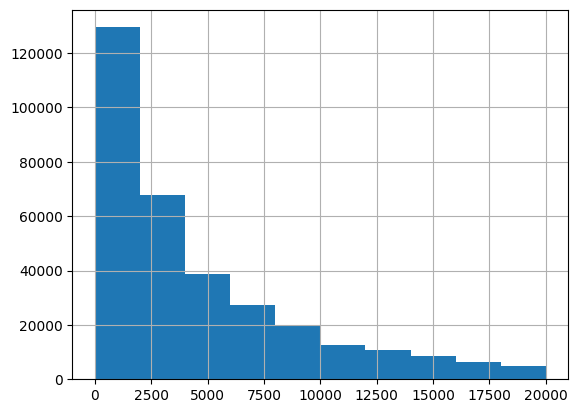

In [42]:
df['Price'].hist() # все равно проверим, не является ли распределением нормальным. 
# Наблюдается правосторонняя ассиметрия распределения

In [43]:
price = sorted(df['Price'])

price_slice = r.sample(price, 5000)

stat_price, p_price = shapiro(price_slice)
print(
    'Statistics=%.3f, p=%.3f' % (
        stat_price,
        p_price
    )
)
alpha = 0.05
if p_price > alpha:
    print(
        'Распределение похоже на Гауссово (не удалось отклонить нулевую гипотезу)'
    )
else:
    print(
        'Распределение не похоже на Гауссово (отклоняем нулевую гипотезу)'
    )

Statistics=0.837, p=0.000
Распределение не похоже на Гауссово (отклоняем нулевую гипотезу)


In [44]:
stat_price_n, p_price_n = normaltest(price_slice)
print(
    'Statistics=%.3f, p=%.3f' % (
    stat_price_n,
    p_price_n
    )
)
alpha = 0.05
if p_price_n > alpha:
    print(
        'Распределение похоже на Гауссово (не удалось отклонить нулевую гипотезу)'
    )
else:
    print(
        'Распределение не похоже на Гауссово (отклоняем нулевую гипотезу)'
    )

Statistics=1104.630, p=0.000
Распределение не похоже на Гауссово (отклоняем нулевую гипотезу)


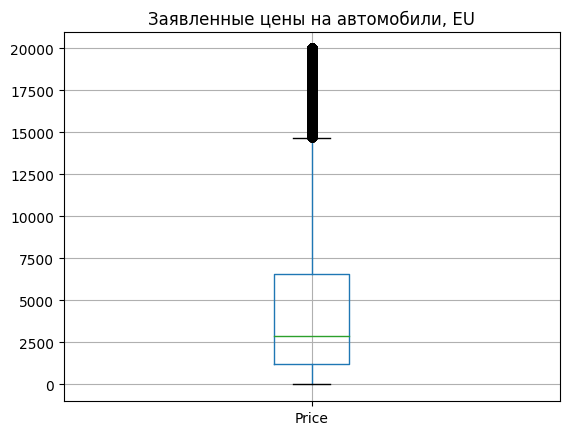

count    326201.000000
mean       4580.683499
std        4569.702049
min           0.000000
25%        1199.000000
50%        2900.000000
75%        6600.000000
max       20000.000000
Name: Price, dtype: float64


In [45]:
df.boxplot(column='Price')

plt.title(
    "Заявленные цены на автомобили, EU"
)

plt.show()

car_price = df['Price'].describe()
print(car_price) 
# Бесплатные автомобили, выглядит как аномалия. Либо ошибка, либо признак криминальной схемы

<a id='tag_3'></a>

In [46]:
print(df[df['Price'] < 1]['Price'].count())

8331


In [47]:
display(df[df['Price'] < 1].head())
# Очевидных закономерностей не прослеживается

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Duration_of_use_mo
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,428
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,unknown,207
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,137
231,0,wagon,2001,manual,115,mondeo,150000,NaN,ford,unknown,183
471,0,NaN,1990,NaN,0,3er,5000,NaN,bmw,unknown,316


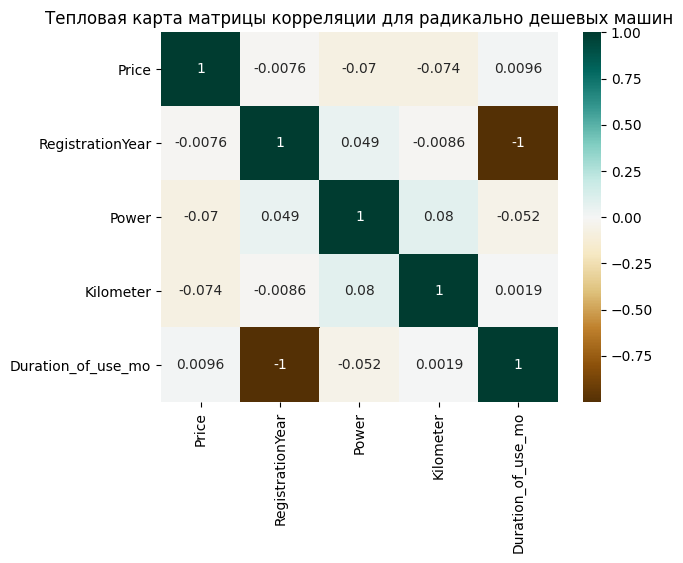

In [48]:
df_plot = sns.heatmap(
    df[df['Price'] < 100].corr()
    , cmap="BrBG",
    annot=True
)
plt.title(
    "Тепловая карта матрицы корреляции для радикально дешевых машин"
)
plt.show()
# Очевидных закономерностей не прослеживается

In [49]:
print(
    df[df['Price'] < 1]['Price'].count().sum()
)
# Бесплатные авто предлагаются в 2.5% объявлений даже после предобработки других признаков. 
# Подозрительно много. Удалим эти данные как аномальные,
# поскольку мы работаем с данными сервиса по продаже авто.

# Кроме того следовало бы проверить эти объявления. Скорее всего они вводят покупателя в заблуждение.
# Возьмем минимальный порог в 100 евро для заявлений о продаже авто.

8331


Бесплатные авто предлагаются в 2.5% объявлений даже после предобработки других признаков. Подозрительно много. Удалим эти данные как аномальные,поскольку мы работаем с данными сервиса по продаже авто.

Кроме того, следовало бы проверить эти объявления. Скорее всего они вводят покупателя в заблуждение. Возьмем минимальный порог в 100 евро для заявлений о продаже авто.

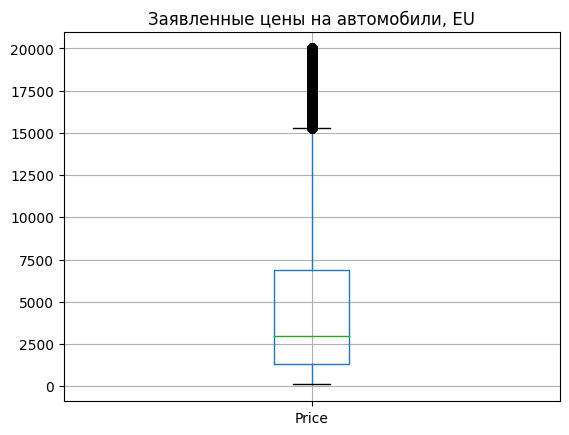

count    315117.000000
mean       4741.362986
std        4566.928994
min         101.000000
25%        1299.000000
50%        3000.000000
75%        6890.000000
max       20000.000000
Name: Price, dtype: float64


In [50]:
df = df[df['Price'] > 100]

df.boxplot(column='Price')

plt.title("Заявленные цены на автомобили, EU")

plt.show()

car_price = df['Price'].describe()
print(car_price) 
# Бесплатные автомобили и радикально дешевые автомобили смещали среднее на 200 евро вниз.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315117 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Price               315117 non-null  int32 
 1   VehicleType         307562 non-null  object
 2   RegistrationYear    315117 non-null  int32 
 3   Gearbox             304406 non-null  object
 4   Power               315117 non-null  int32 
 5   Model               302239 non-null  object
 6   Kilometer           315117 non-null  int32 
 7   FuelType            297747 non-null  object
 8   Brand               315117 non-null  object
 9   Repaired            315117 non-null  object
 10  Duration_of_use_mo  315117 non-null  int32 
dtypes: int32(5), object(6)
memory usage: 22.8+ MB


### Попробуем заменить пропуски 

In [52]:
df.shape[0] - df.dropna().shape[0]
# Пропуски затрагивают около 12% данных, все еще много.

37580

In [53]:
df_model_vehicle_type = pd.crosstab(
    [df.Brand, df.Model],
    df['VehicleType']
)
display(df_model_vehicle_type.head(32))
# Из данных видно, что закономерности не наблюдается. Заменить данные на основе категориальных данных не выйдет

VehicleType         bus  convertible  coupe  other  sedan  small  suv  wagon
Brand      Model                                                            
alfa_romeo 145        0            0      2      1     12     19    0      0
           147        0            0     26      6    358     93    0      2
           156        0            0      3      1    265      2    0    281
           159        0            0      0      0     55      0    0    143
           other      0            1    178      4    179    114    0      6
           spider     0          176      1      0      0      0    0      0
audi       100        0            1      2      0    263      0    0    103
           200        0            1      0      0     15      0    0      1
           80         0          156     49      8    946      2    0    199
           90         0            1      6      0     71      0    0      1
           a1         0            0      1      0     45    525    0      0
           a2         6            0      0      6     39    289    0      1
           a3         0          150    235     65   2831    590    1   1404
           a4         1          532      3      6   3437     62    1   5149
           a5         0           38    410      3     66      0    0      2
           a6         1            0      0      3   1792      1    7   3302
           a8         0            0      0      0    480      0    0      1
           other      0          308    110      8    205      7    7    345
           q3         0            0      0      0      8      0    3      1
           q5         0            0      0      0     43      0   52      0
           q7         0            0      0      0     92      0   99      2
           tt         0          394    600      1      2      6    0      0
bmw        1er        0          251    241     20   2642    138    0     20
           3er        2         2148   2988    175   7879    254    3   4469
           5er        1            0      0      3   4360      3    1   2957
           6er        0           24    107      1      4      0    0      0
           7er        0            1      0      1    907      0    0      0
           i3         0            1      0      0      4      1    0      1
           m_reihe    0           23     43      1     45      0    1      1
           other      0           11     49      3     70      8    1     16
           x_reihe    3            0      0      1    725      0  770      8
           z_reihe    0          646     50      0      1      0    0      0

In [54]:
interval_cols = df.select_dtypes(include=['int32'])
df_blind = df.fillna('unknown')
#df_blind = df.select_dtypes(include=['object'])

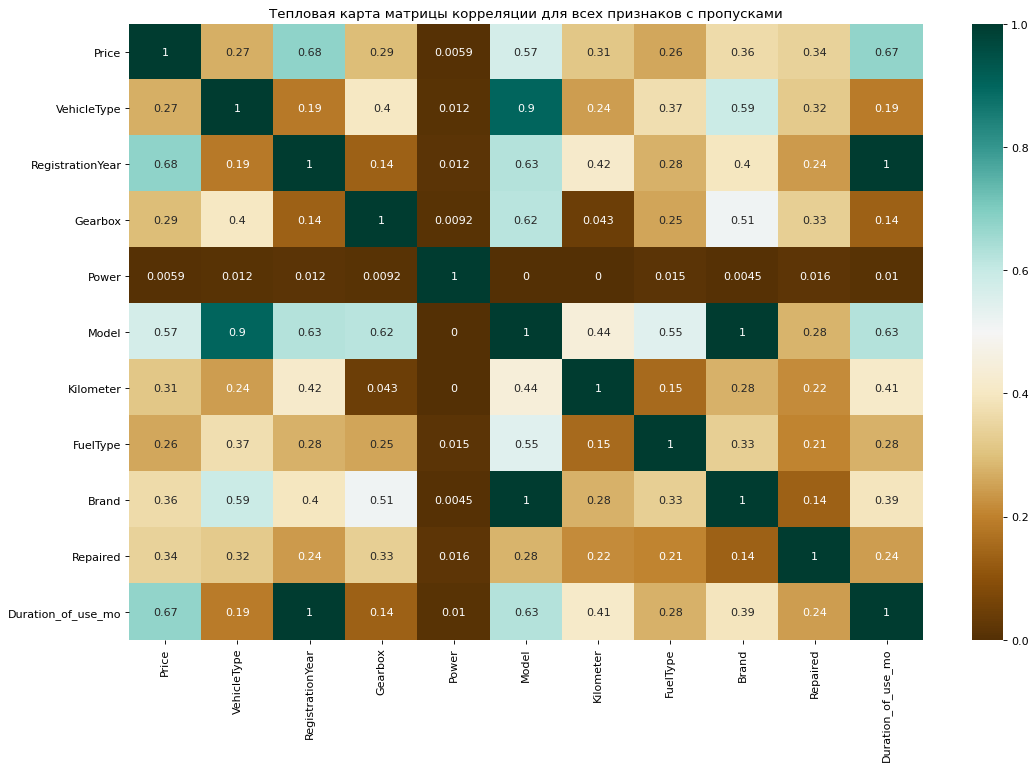

In [55]:
heat_map(
    df_blind.phik_matrix(interval_cols= interval_cols),
    "Тепловая карта матрицы корреляции для всех признаков с пропусками"
)

Похоже что все модели автомобилей (Model) имеют уникальное название и встречаются только в рамках конкретного брэнда (Brand). Корреляция между этими признаками равна 1. Это могло бы помочь нам в случае наличия пропусков в столбце с признаком (Brand).

Также сильная корреляция (0.92) наблюдается между моделью автомобиля (Model) и типом кузова (VehicleType).

In [56]:
df_clean = df.dropna()

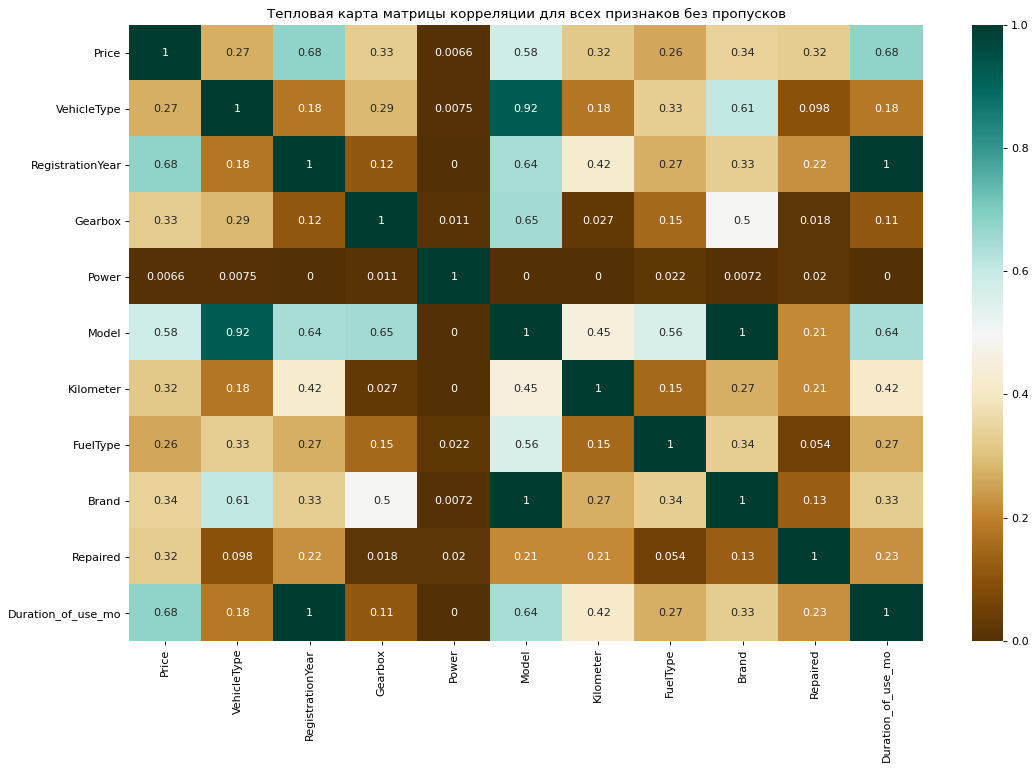

In [57]:
heat_map(
    df_clean.phik_matrix(interval_cols=interval_cols),
    "Тепловая карта матрицы корреляции для всех признаков без пропусков"
)
# Заполнение пропусков заглушкой оказывает слабое влияние на корреляцию, не более 0.01

Заполнение пропусков заглушкой оказывает слабое влияние на корреляцию, не более 0.03. При этом сохраняется около 12% данных

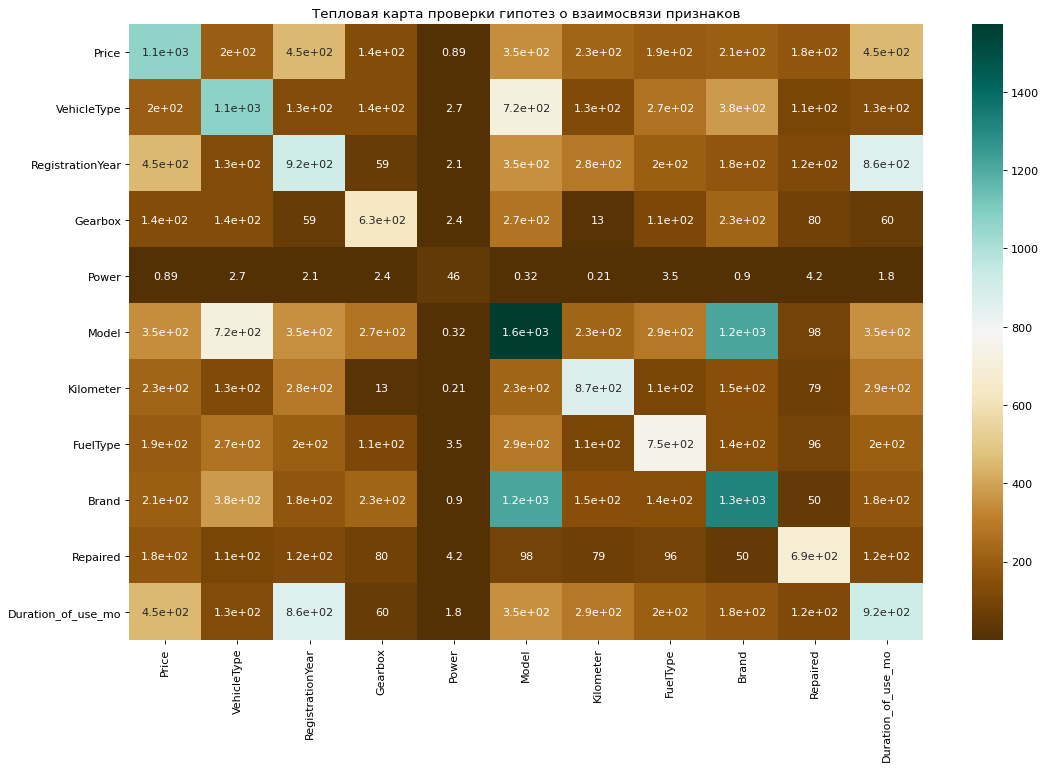

In [58]:
heat_map(
    df_blind.significance_matrix(interval_cols=interval_cols), 
    "Тепловая карта проверки гипотез о взаимосвязи признаков"
)

Все гипотезы о взаимосвязи категориальных признаков опровергнуты. Все гипотезы имеют p-value выше уровня статистической значимости в 5%. Наиболее близки к стат значимым гипотезы о взаимосвязи признаков Brand и Model, а также года регистрации (RegistrationYear) и пробега (Duration_of_use_mo).

In [59]:
df = df.fillna('unknown') # Заполняем все пропуски заглушками.

encoder = OrdinalEncoder()

column = df.select_dtypes(include=['object']).columns
df_codes = copy.deepcopy(df)
df_codes[column] = encoder.fit_transform(df_codes[column])

df_codes.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Duration_of_use_mo
0,480,7.0,1993,1.0,0,116.0,150000,6.0,38.0,1.0,279
1,18300,2.0,2011,1.0,190,228.0,125000,2.0,1.0,2.0,58
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0,139
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0,177
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,92


In [60]:
df_codes = df_codes.astype('int32')

In [61]:
#heat_map(df_codes.corr(), "Тепловая карта матрицы корреляции для всех признаков")    

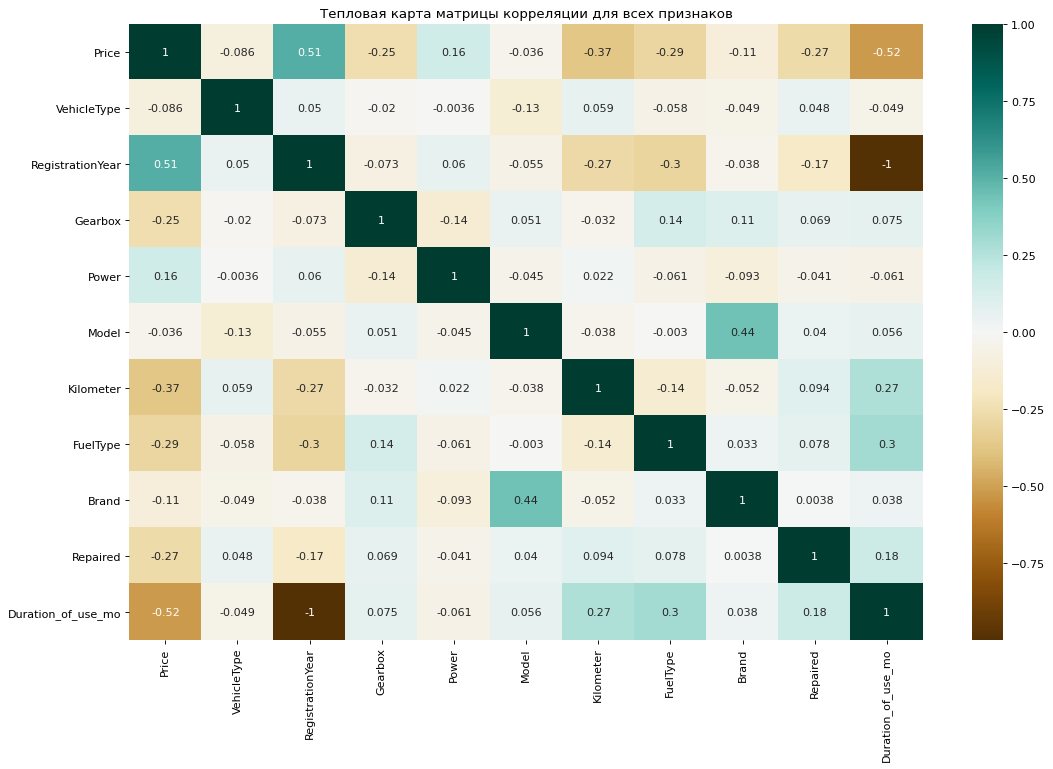

In [62]:
heat_map(
    df_codes.corr(), 
    "Тепловая карта матрицы корреляции для всех признаков"
)

In [63]:
X = add_constant(df_codes)  
ds=pd.Series(
    [variance_inflation_factor(
        X.values, i
    ) for i in range(X.shape[1])], 
    index=X.columns
)  
print(ds)

const                 4.509740e+07
Price                 1.832334e+00
VehicleType           1.045619e+00
RegistrationYear      4.566379e+02
Gearbox               1.113332e+00
Power                 1.047823e+00
Model                 1.267770e+00
Kilometer             1.327719e+00
FuelType              1.266347e+00
Brand                 1.274390e+00
Repaired              1.089883e+00
Duration_of_use_mo    4.578591e+02
dtype: float64


Коэффециент инфляции дисперсии признаков RegistrationYear и Duration_of_use_mo высокий, почти равен 5. К тому же корреляция между этими двумя признаками равна -1.  Мультиколлиниарность приведет к снижению качества модели.

Заменим признаки на столбец, характерезующий возраст автомобиля категориальной переменной.

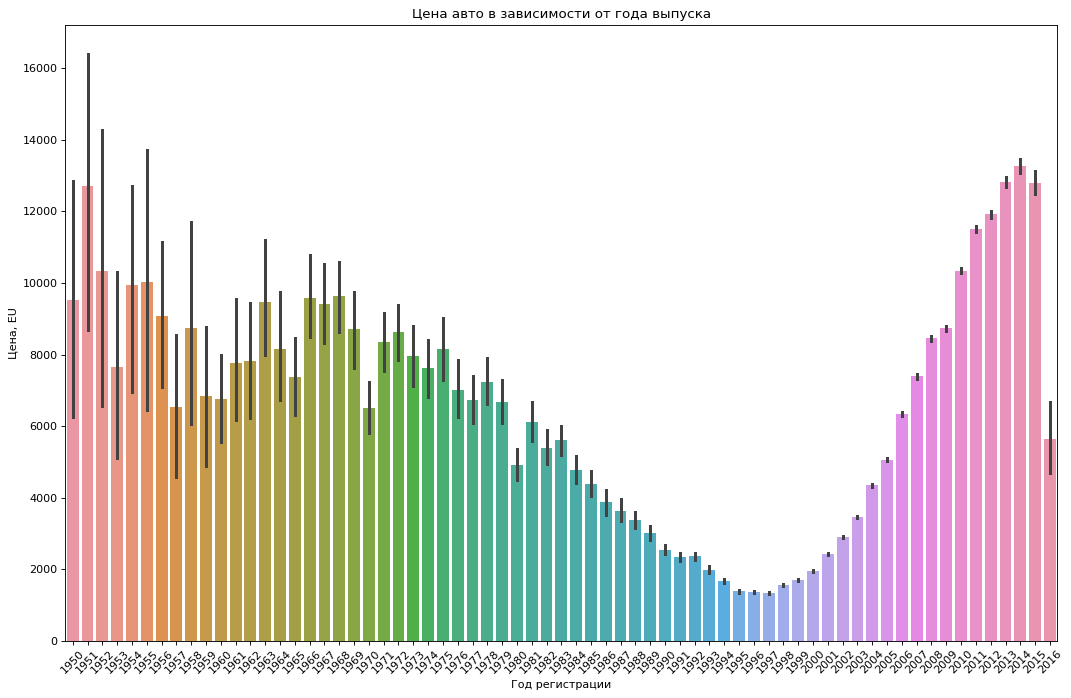

In [64]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
sns.barplot(
    x='RegistrationYear',
    y='Price',
    data=df
)

plt.title('Цена авто в зависимости от года выпуска')
plt.xticks(rotation=45)
plt.xlabel('Год регистрации')
plt.ylabel('Цена, EU')
plt.show()

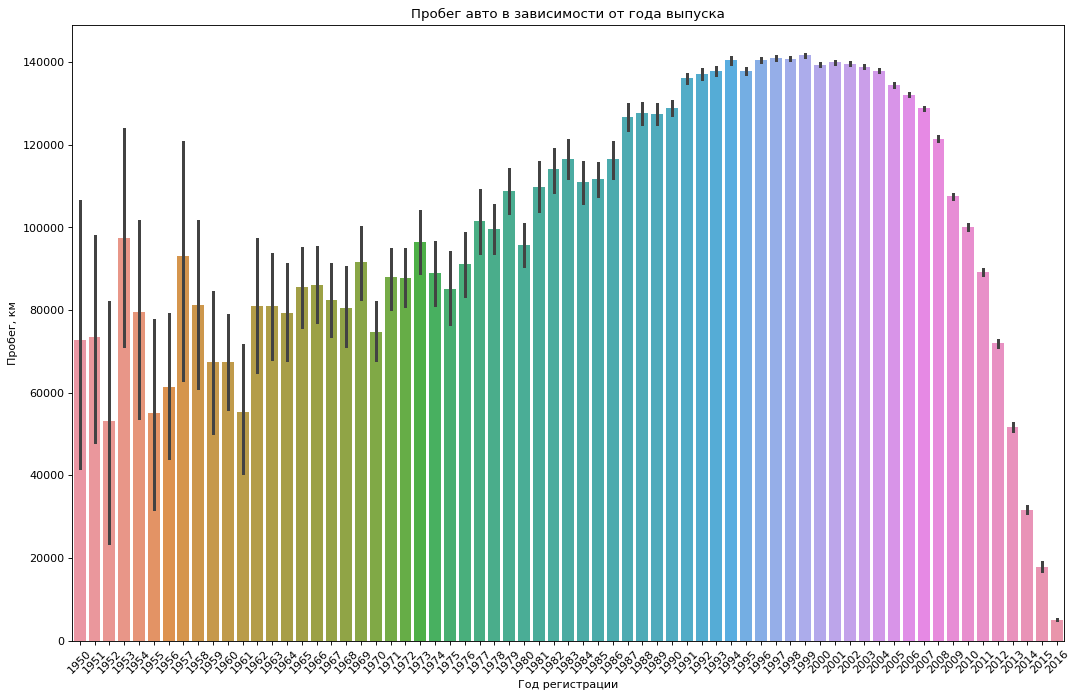

In [65]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
sns.barplot(
    x='RegistrationYear',
    y='Kilometer',
    data=df
)

plt.title('Пробег авто в зависимости от года выпуска')
plt.xticks(rotation=45)
plt.xlabel('Год регистрации')
plt.ylabel('Пробег, км')
plt.show()

Введем новый столбец характеризующие автомобили по году выпуска (СarСategory):
- Новые автомобили, срок гарантии на которые скорее всего не истек: F (2013-2016)
- Автомобили с небольшим пробегом: E (2006 - 2012)
- Подержанные авто c большим пробегом: D (1987 - 2005)

По классификации Международной федерации старинных автомобилей (FIVA) 
- Class G: C (1971 - 1986)
- Class F: B (1961 - 1970)
- Послевоенные(Post War): A (до 1960)

In [66]:
def categorize_income(income):
    try:
        if 2013 <= income <= 2016:
            return 'F'
        elif 2006 <= income <= 2012:
            return 'E'
        elif 1987 <= income <= 2005:
            return 'D'
        elif 1971 <= income <= 1986:
            return 'C'
        elif 1961 <= income <= 1970:
            return 'B'
        elif income <= 1960:
            return 'A'
    except:
        pass

In [67]:
df['СarСategory'] = df['RegistrationYear'].apply(categorize_income)

In [68]:
df = df.drop('Duration_of_use_mo', axis=1) # Эта метрика приводит к мультикаллиарности. Зря ее ввел

In [69]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,СarСategory
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown,D
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,E
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,D
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,D
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,E


In [70]:
column = df.select_dtypes(include=['object']).columns
df_codes = copy.deepcopy(df)
df_codes[column] = encoder.fit_transform(df_codes[column])

df_codes.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,СarСategory
0,480,7.0,1993,1.0,0,116.0,150000,6.0,38.0,1.0,3.0
1,18300,2.0,2011,1.0,190,228.0,125000,2.0,1.0,2.0,4.0
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0,3.0
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0,3.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,4.0


In [71]:
df_codes = df_codes.astype('int32')

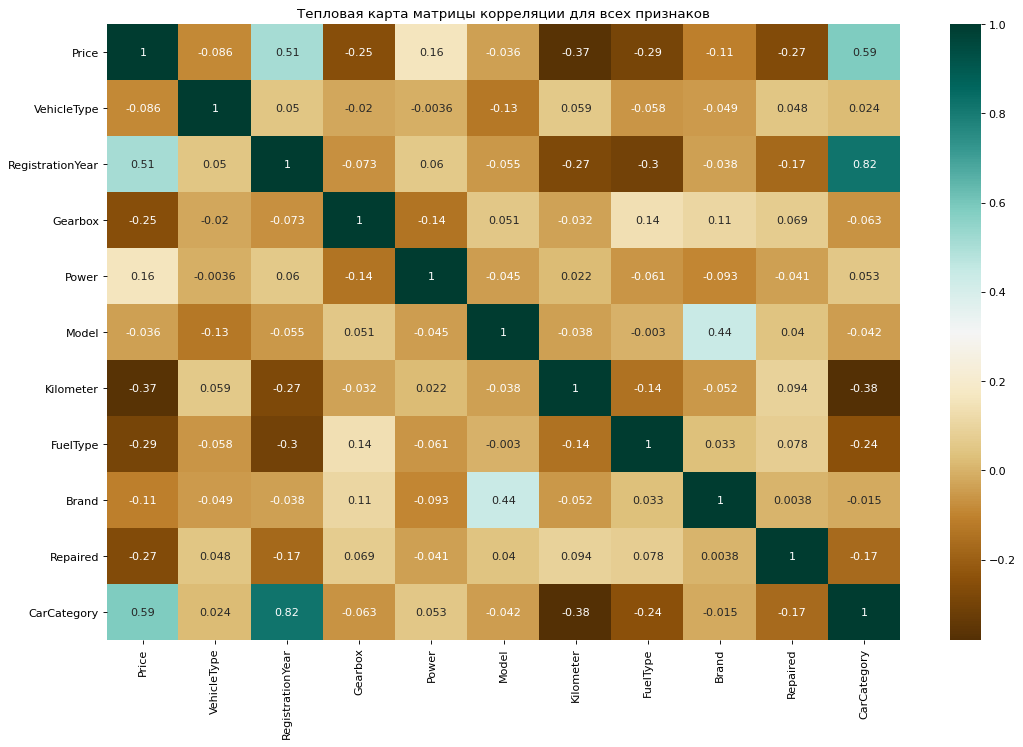

In [72]:
heat_map(
    df_codes.corr(),
    "Тепловая карта матрицы корреляции для всех признаков"
)

In [73]:
X = add_constant(df_codes)  
ds=pd.Series(
    [variance_inflation_factor(
        X.values,
        i
    ) for i in range(X.shape[1])],
    index=X.columns)  
print(ds)

const               300282.341924
Price                    1.987369
VehicleType              1.046195
RegistrationYear         3.168852
Gearbox                  1.115416
Power                    1.048242
Model                    1.267902
Kilometer                1.376651
FuelType                 1.261766
Brand                    1.277540
Repaired                 1.083414
СarСategory              3.600841
dtype: float64


Коэффециент инфляции дисперсии признаков RegistrationYear и Duration_of_use_mo снижен и анходится на уровне 3.6. Хотя корреляция между признаками равняется 0.82, кажется, что мультиколлиреальности удалось избежать. 

После удаления аномальных значений прослеживается средняя кореляция между моделью авто (Model) и брэндом (Brand) = **0.44**. 

Появилась корреляция между многими признаками. Так, проявилась средняя корреляция между ценой (Price) и годом выпуска (RegistrationYear) = **0.51**. Также проявилась средняя корреляция между ценой (Price) и введенной переменной (CarCategory) **0.59**.

In [74]:
df_codes.head(10)
# Выполнили преобразование с методом Ordinal Encoding. 
# Если будем наблюдать низкое качество модели, попробуем удалить все пропуски.

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,СarСategory
0,480,7,1993,1,0,116,150000,6,38,1,3
1,18300,2,2011,1,190,228,125000,2,1,2,4
2,9800,6,2004,0,163,117,125000,2,14,1,3
3,1500,5,2001,1,75,116,150000,6,38,0,3
4,3600,5,2008,1,69,101,90000,2,31,0,4
5,650,4,1995,1,102,11,150000,6,2,2,3
6,2200,1,2004,1,109,8,150000,6,25,0,3
8,14500,0,2014,1,125,60,30000,6,10,1,5
9,999,5,1998,1,101,116,150000,7,38,1,3
10,2000,4,2004,1,105,10,150000,6,19,0,3


In [75]:
df_codes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315117 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Price             315117 non-null  int32
 1   VehicleType       315117 non-null  int32
 2   RegistrationYear  315117 non-null  int32
 3   Gearbox           315117 non-null  int32
 4   Power             315117 non-null  int32
 5   Model             315117 non-null  int32
 6   Kilometer         315117 non-null  int32
 7   FuelType          315117 non-null  int32
 8   Brand             315117 non-null  int32
 9   Repaired          315117 non-null  int32
 10  СarСategory       315117 non-null  int32
dtypes: int32(11)
memory usage: 23.7 MB


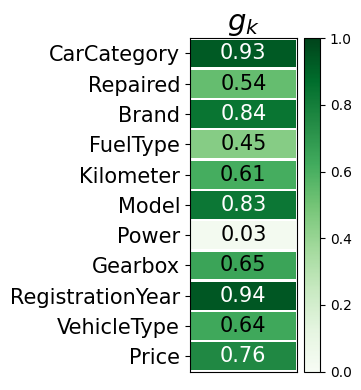

In [76]:
interval_cols = df_codes.select_dtypes(include=['int32'])
global_correlation, global_labels = df_codes.global_phik(
    interval_cols=interval_cols
)

plot_correlation_matrix(
    global_correlation, 
    x_labels=[''], 
    y_labels=global_labels, 
    vmin=0, 
    vmax=1, 
    figsize=(3.5,4),
    color_map="Greens",
    title=r"$g_k$",
    fontsize_factor=1.5
)

Модель должна работать хорошо. Целевой признак Price имеет высокий показатель глобальной корреляции (**0.76**).

**Вывод:**

пропуски в данных не удалось заполнить на основании имеющихся данных. Все пропуски заполнены заглушками.

Также в данных обнаружено множество анамальных значений:
1. Связанные с [датой регистрации автомобиля](#tag_1)
2. Связанные с [пробегом и обилием пропусков в данных](#tag_2)
3. Связанные с [0 ценой на автомобили](#tag_3)

Подобные аномалии косвенно могут свидетельствовать о недобросовестности продавцов. Возможно, стоит изучить подобные заявления подробнее. Возможно, целесообразно внести изменения в форму анкеты, дабы присечь хотя бы часть из них.

В датафрейме [отсутствют](#tag_4) данные о фотографиях. Их либо нет вообще, либо выгрузка была произведена некорректно.

### Обучение моделей

#### Выделяем тестовую, валидационную и обучающую выборки

In [77]:
X = df_codes.drop('Price', axis=1)
y = df_codes['Price']

train_future, temp_future, train_target, y_temp = train_test_split(X,
                                                      y,
                                                      test_size=.4,
                                                      random_state=12345)

    
val_future, test_future, val_target, test_target = train_test_split(temp_future,
                                                  y_temp,
                                                  test_size=.2,
                                                  random_state=12345)

In [78]:
print(
    train_future.shape,
    train_target.shape,
    val_future.shape,
    val_target.shape,
    test_future.shape,
    test_target.shape
)

(189070, 10) (189070,) (100837, 10) (100837,) (25210, 10) (25210,)


#### Нормализуем данные

In [79]:
ss = StandardScaler()
train_future = ss.fit_transform(train_future)
test_future = ss.transform(test_future)
val_future = ss.transform(val_future)

#### Модель решающего древа

##### Проверим на базовой модели решающего дерева

In [80]:
def predict_and_score(model, future, target): # функция вычисления предсказания и целевой метрики RMSE
    predict = model.predict(future)
    RMSE = (mean_squared_error(target, predict)) ** .5
    print('RMSE = {:.0F}'.format(RMSE))
    return RMSE

In [81]:
def time_to_time(name_model, train_time, predict_time, RMSE): # функция построения таблицы с результатами
    x = [[name_model, train_time, predict_time, RMSE]]
    y = pd.DataFrame(x, columns=['model', 'train_time', 'predict_time', 'RMSE'])
    return y

In [82]:
start_time = time.time()
tree_model_basic = DecisionTreeRegressor(random_state=12345)
tree_model_basic.fit(train_future, train_target)
predict_time_b_t_t = time.time() - start_time

start_time = time.time()
RMSE_1 = predict_and_score(tree_model_basic, val_future, val_target)
predict_time_b_p_t = time.time() - start_time
print('Время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'\
      .format(predict_time_b_t_t, predict_time_b_p_t))

filename = 'tree_model_basic.pkl'

frame_1 = time_to_time(filename, predict_time_b_t_t, predict_time_b_p_t, RMSE_1)

joblib.dump(tree_model_basic, filename)

RMSE = 1991
Время обучения модели: 1.318 
Время предсказания модели: 0.065 сек.


['tree_model_basic.pkl']

##### Проверим модель с подбором лучших параметров

In [83]:
%%time

tree_model = DecisionTreeRegressor(random_state=12345)
parametrs = {
'max_depth': range (1, 9, 2),
    'min_samples_leaf': range (1, 11, 2),
    'min_samples_split': range (2, 11, 2)
}

best_tree_model = GridSearchCV(
    tree_model,
    parametrs,
    cv = 5,
    n_jobs = -1,
    scoring='neg_root_mean_squared_error'
)

best_tree_model.fit(train_future, train_target)


cv_tree_results = pd.DataFrame(best_tree_model.cv_results_)
best_tree_results = cv_tree_results.loc[best_tree_model.best_index_]
print(best_tree_results)

mean_fit_time                                                       0.704003
std_fit_time                                                        0.029278
mean_score_time                                                     0.010797
std_score_time                                                      0.004168
param_max_depth                                                            7
param_min_samples_leaf                                                     7
param_min_samples_split                                                    2
params                     {'max_depth': 7, 'min_samples_leaf': 7, 'min_s...
split0_test_score                                               -2179.149212
split1_test_score                                                -2200.55146
split2_test_score                                               -2199.967788
split3_test_score                                               -2163.783808
split4_test_score                                               -2178.477249

In [84]:
#start_time = time.time()
#best_tree_model.fit(train_future, train_target)
#predict_time_l_t_t = time.time() - start_time

start_time = time.time()
RMSE_2 = predict_and_score(best_tree_model, val_future, val_target)
predict_time_l_p_t = time.time() - start_time

print(
    'Среднее время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'.format(
        np.mean(best_tree_model.cv_results_['mean_fit_time']),
        predict_time_l_p_t
    )
)

filename = 'best_tree_model.pkl'

frame_2 = time_to_time(
    filename,
    np.mean(best_tree_model.cv_results_['mean_fit_time']),
    predict_time_l_p_t,
    RMSE_2
)

joblib.dump(best_tree_model, filename)

RMSE = 2171
Среднее время обучения модели: 0.517 
Время предсказания модели: 0.016 сек.


['best_tree_model.pkl']

#### Модель случайного леса

##### Проверим на базовой модели решающего дерева


In [85]:
start_time = time.time()
forest_model_basic = RandomForestRegressor(random_state=12345)
forest_model_basic.fit(train_future, train_target)
predict_time_b_t_f = time.time() - start_time

start_time = time.time()
RMSE_3 = predict_and_score(forest_model_basic, val_future, val_target)
predict_time_b_p_f = time.time() - start_time

print(
    'Время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'.format(
    predict_time_b_t_f, predict_time_b_p_f
    )
)

filename = 'forest_model_basic.pkl'

frame_3 = time_to_time(
    filename,
    predict_time_b_t_f,
    predict_time_b_p_f,
    RMSE_3
)


joblib.dump(forest_model_basic, filename)

RMSE = 1611
Время обучения модели: 88.791 
Время предсказания модели: 4.619 сек.


['forest_model_basic.pkl']

##### Проверим модель с подбором лучших параметров

In [86]:
%%time

forest_model = RandomForestRegressor(random_state=12345)
parametrs = {
    'n_estimators': range (1, 11, 2),
    'max_depth': range (1, 9, 2),
    'min_samples_leaf': range (1, 11, 2),
    'min_samples_split': range (2, 11, 2)
}

best_forest_model = GridSearchCV(
    forest_model,
    parametrs,
    cv = 5,
    n_jobs = -1,
    scoring='neg_root_mean_squared_error'
)

best_forest_model.fit(train_future, train_target)


cv_tree_results = pd.DataFrame(best_forest_model.cv_results_)
best_forest_results = cv_tree_results.loc[best_forest_model.best_index_]
print(best_forest_results)

mean_fit_time                                                       4.431525
std_fit_time                                                        0.147229
mean_score_time                                                       0.0404
std_score_time                                                      0.003073
param_max_depth                                                            7
param_min_samples_leaf                                                     1
param_min_samples_split                                                    8
param_n_estimators                                                         9
params                     {'max_depth': 7, 'min_samples_leaf': 1, 'min_s...
split0_test_score                                               -2128.826461
split1_test_score                                               -2147.672108
split2_test_score                                               -2140.641673
split3_test_score                                               -2102.120875

In [87]:
start_time = time.time()
RMSE_4 = predict_and_score(best_forest_model, val_future, val_target)
predict_time_l_p_f = time.time() - start_time

print(
    'Время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'.format(
    np.mean(best_forest_model.cv_results_['mean_fit_time']),
    predict_time_l_p_f
    )
)

filename = 'best_forest_model.pkl'

frame_4 = time_to_time(
    filename,
    np.mean(best_forest_model.cv_results_['mean_fit_time']),
    predict_time_l_p_f,
    RMSE_4
)

joblib.dump(best_forest_model, filename)

RMSE = 2124
Время обучения модели: 1.582 
Время предсказания модели: 0.095 сек.


['best_forest_model.pkl']

##### Посмотрим результаты модели с использованием градиентного бустинга LightGBM

In [88]:
model_lgbm = LGBMRegressor(num_leaves=62, learning_rate=0.25, random_state=12345, n_jobs=- 1)

n_scores = cross_val_score(model_lgbm, train_future, train_target, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

print('Среднее RMSE при кросс-валидации на обучающей выборке: {:.0f}'.format(np.abs(n_scores.mean())))

start_time = time.time()
model_lgbm.fit(train_future, train_target)
predict_time_lgbm_p_lgbm = time.time() - start_time

start_time = time.time()
RMSE_5 = predict_and_score(model_lgbm, val_future, val_target)

predict_time_lgbm_f_lgbm = time.time() - start_time

print(
    'Время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'.format(
    predict_time_lgbm_p_lgbm,
    predict_time_lgbm_f_lgbm
    )
)

filename = 'model_lgbm.pkl'

frame_5 = time_to_time(
    filename, 
    predict_time_lgbm_p_lgbm, 
    predict_time_lgbm_f_lgbm, 
    RMSE_5
)

joblib.dump(model_lgbm, filename)

Среднее RMSE при кросс-валидации на обучающей выборке: 1604
RMSE = 1576
Время обучения модели: 1.086 
Время предсказания модели: 0.188 сек.


['model_lgbm.pkl']

##### Подберем параметры для градиентного бустинга LightGBM

In [89]:
%%time

name_types = ['gbdt', 'dart', 'goss']

model_lgbm_b = LGBMRegressor(random_state=12345)
parametrs = {
    'num_leaves': range (21, 81, 10),
    'learning_rate': np.arange(0.05,0.4,0.05),
    'boosting_type': [x for x in name_types],
}

best_lgbm_model = GridSearchCV(
    model_lgbm_b,
    parametrs,
    cv = 5,
    n_jobs = -1,
    scoring='neg_root_mean_squared_error'
)

best_lgbm_model.fit(train_future, train_target)

CPU times: total: 14.5 s
Wall time: 11min 27s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
                         'num_leaves': range(21, 81, 10)},
             scoring='neg_root_mean_squared_error')

In [90]:
print(best_lgbm_model.best_estimator_)

LGBMRegressor(learning_rate=0.35000000000000003, num_leaves=71,
              random_state=12345)


In [91]:
print(
    'Время обучения на обучающей выборке: {:.2f} \nRMSE: {:.2f}'.format(
        best_lgbm_model.cv_results_['mean_fit_time'].mean(),
        abs(best_lgbm_model.cv_results_['mean_test_score'].mean())
    )
)

Время обучения на обучающей выборке: 5.98 
RMSE: 1709.15


In [92]:
start_time = time.time()
RMSE_6 = predict_and_score(best_lgbm_model, val_future, val_target)
predict_time_l_p_f = time.time() - start_time

best_lgbm_model = best_lgbm_model
print(
    'Время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'.format(
        np.mean(best_lgbm_model.cv_results_['mean_fit_time']),
        predict_time_l_p_f
    )
)

filename = 'best_model_lgbm.pkl'

frame_6 = time_to_time(
    filename, 
    np.mean(best_forest_model.cv_results_['mean_fit_time']),
    predict_time_l_p_f,
    RMSE_6
)

joblib.dump(best_lgbm_model, filename)

RMSE = 1570
Время обучения модели: 5.982 
Время предсказания модели: 0.223 сек.


['best_model_lgbm.pkl']

#### Посмотрим случайную модель, заполняющую средним для оценки адекватности моделей

In [93]:
pseudorandom_model = DummyRegressor(strategy='mean')

scores = cross_val_score(pseudorandom_model, train_future, train_target, cv=5,
                         scoring='neg_root_mean_squared_error', n_jobs=-1) 
mean_score = np.abs(scores.mean())
print('Средний RMSE для случайной выборки: {:.0f}'.format(mean_score))

start_time = time.time()
pseudorandom_model.fit(train_future, train_target)
predict_time_pseudorandom_p = time.time() - start_time

start_time = time.time()
RMSE_7 = predict_and_score(pseudorandom_model, val_future, val_target)

predict_time_pseudorandom_f = time.time() - start_time
print(
    'Время обучения модели: {:.3F} \nВремя предсказания модели: {:.3f} сек.'.format(
        predict_time_pseudorandom_p,
        predict_time_pseudorandom_f
    )
)

filename = 'pseudorandom_model.pkl'

frame_7 = time_to_time(
    filename,
    predict_time_pseudorandom_p,
    predict_time_pseudorandom_f,
    RMSE_7
)

joblib.dump(pseudorandom_model, filename)
# Среднее предсказание значительно хуже других моделей

Средний RMSE для случайной выборки: 4580
RMSE = 4555
Время обучения модели: 0.001 
Время предсказания модели: 0.002 сек.


['pseudorandom_model.pkl']

### Определим лучшую модель

In [94]:
frames = [frame_1, frame_2, frame_3, frame_4, frame_5, frame_6]
df_time = pd.concat(frames)
display(df_time)

,model,train_time,predict_time,RMSE
0,tree_model_basic.pkl,1.318001,0.064997,1990.749146
0,best_tree_model.pkl,0.516757,0.016000,2171.287578
0,forest_model_basic.pkl,88.790645,4.619054,1611.437051
0,best_forest_model.pkl,1.581734,0.094999,2123.890276
0,model_lgbm.pkl,1.086004,0.187995,1575.936643
0,best_model_lgbm.pkl,1.581734,0.223000,1569.963017


In [95]:
df_time_1 = df_time[df_time.RMSE <= 2500].reset_index(drop=True)

In [96]:
display(df_time_1)

,model,train_time,predict_time,RMSE
0,tree_model_basic.pkl,1.318001,0.064997,1990.749146
1,best_tree_model.pkl,0.516757,0.016000,2171.287578
2,forest_model_basic.pkl,88.790645,4.619054,1611.437051
3,best_forest_model.pkl,1.581734,0.094999,2123.890276
4,model_lgbm.pkl,1.086004,0.187995,1575.936643
5,best_model_lgbm.pkl,1.581734,0.223000,1569.963017


In [97]:
target_columns = ['train_time', 'predict_time', 'RMSE']
norm_df_time = ss.fit_transform(df_time_1[target_columns])
norm_df_time = pd.DataFrame(norm_df_time, columns=target_columns)
display(norm_df_time)

norm_df_time['sum'] = norm_df_time[target_columns].sum(axis=1) # Рассчитываем сумму и выбираем минимум
df_time_1['sum'] = norm_df_time['sum']

,train_time,predict_time,RMSE
0,-0.444087,-0.478028,0.576039
1,-0.468636,-0.507208,1.268407
2,2.235931,2.234107,-0.878629
3,-0.436007,-0.460161,1.086638
4,-0.451195,-0.404778,-1.014774
5,-0.436007,-0.383931,-1.037682


In [98]:
norm_df_time['sum']

0   -0.346076
1    0.292563
2    3.591409
3    0.190470
4   -1.870746
5   -1.857620
Name: sum, dtype: float64

In [99]:
feature_importances_model_lgbm = (
    model_lgbm.feature_importances_ / sum(model_lgbm.feature_importances_)
) * 100

model_lgbm_results = pd.DataFrame(
    {'Features': X.columns,
     'Importances': feature_importances_model_lgbm.round(1)}
)


tree_model_basic_results = pd.DataFrame(
    {'Features': X.columns,
     'Importances': (tree_model_basic.feature_importances_ * 100).round(1)}
)

display(model_lgbm_results, tree_model_basic_results)

,Features,Importances
0,VehicleType,9.0
1,RegistrationYear,21.7
2,Gearbox,2.9
3,Power,22.1
4,Model,15.1
5,Kilometer,9.8
6,FuelType,3.3
7,Brand,13.1
8,Repaired,3.0
9,СarСategory,0.0


,Features,Importances
0,VehicleType,3.6
1,RegistrationYear,14.7
2,Gearbox,1.0
3,Power,24.7
4,Model,3.7
5,Kilometer,3.5
6,FuelType,0.9
7,Brand,3.9
8,Repaired,1.6
9,СarСategory,42.4


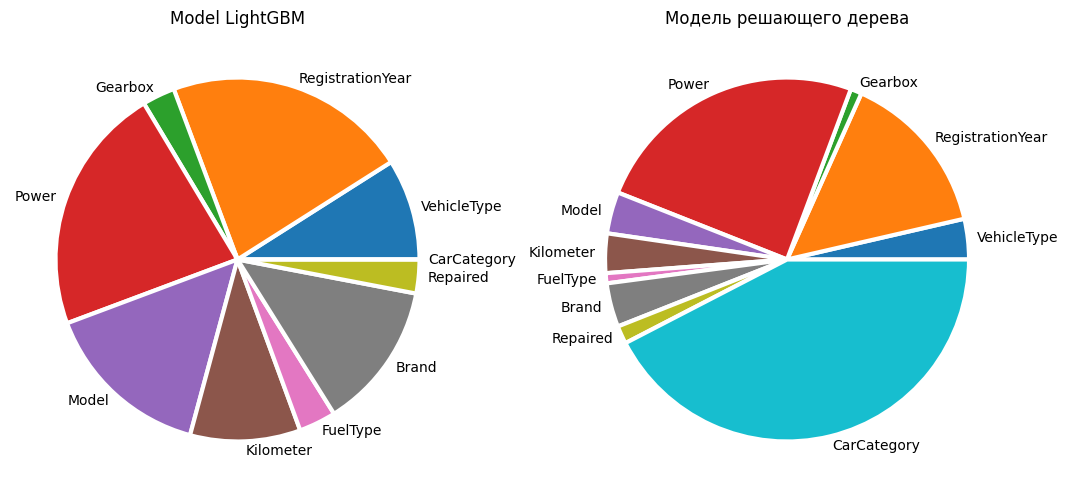

In [100]:
plt.figure(figsize=(13, 13))


plt.subplot(2, 2, 1)
plt.pie(
    model_lgbm_results['Importances'],
    labels=model_lgbm_results['Features'],
    labeldistance=1.05, 
    wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white' }
);
plt.title('Model LightGBM')

plt.subplot(2, 2, 2)
plt.pie(
    tree_model_basic_results['Importances'],
    labels=tree_model_basic_results['Features'],
    labeldistance=1.05,
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }
);
plt.title('Модель решающего дерева')

plt.show()

При использовании модели LightGBM наиболее важными оказались признаки RegistrationYear (**21.7%**) и Power (**22.1%**).

При использовании модели решающего дерева ключевым оказался введенный признак CarCategory (**42.4%**).

In [101]:
best_time = df_time_1[df_time_1['sum'] == df_time_1['sum'].min()] # Фиксируем модель с лучшими показателями
display(df_time_1['sum'].sort_values())

4   -1.870746
5   -1.857620
0   -0.346076
3    0.190470
1    0.292563
2    3.591409
Name: sum, dtype: float64

### Протестируем лучшую модель на тестовой выборке

In [102]:
best_model = best_time['model'].loc[best_time.index[0]]
model = joblib.load(best_model)

In [103]:
start_time = time.time()

best_model = best_time['model'].loc[best_time.index[0]] # Извлекаем название лучшей модели

predict = model.predict(test_future)
RMSE = (mean_squared_error(test_target, predict)) ** .5
print('RMSE = {:.0F}'.format(RMSE))
    
predict_time_b_p_f = time.time() - start_time

print('Время предсказания модели: {:.3f} сек.'\
      .format(predict_time_b_p_f))

RMSE = 1577
Время предсказания модели: 0.080 сек.


**Заключение:**

В данных обнаружено множество анамальных значений:
1. Связанные с [датой регистрации автомобиля](#tag_1)
2. Связанные с [пробегом и обилием пропусков в данных](#tag_2)
3. Связанные с [0 ценой на автомобили](#tag_3)

Подобные аномалии косвенно могут свидетельствовать о недобросовестности продавцов. Возможно, стоит изучить подобные заявления подробнее. Возможно, целесообразно внести изменения в форму анкеты, дабы присечь хотя бы часть из них.

В датафрейме [отсутствют](#tag_4) данные о фотографиях. Их либо нет вообще, либо выгрузка была произведена некорректно.


Лучше прочих себя показала модель градиентного бустинга LightGBM:
- Время обучения: **4.1 сек.**
- Время предсказания: **0.4 сек.** (валидационная выборка)
- RMSE: **1575** (валидационная выборка) и **1570** (тестовая выборка)

Также перспективно выглядит модель решающего дерева с подборкой лучших параметров. Она показала лучшее время, но имеет менее точные предсказания:
- Время обучения: **0.56 сек**.
- Время предсказания: **0.03 сек.** (валидационная выборка)
- RMSE: **2188** (валидационная выборка)

Модель заполнения средним показала RSME = 4555. Остальные модели показали результат лучше случайной модели и менее заданного порога RSME = 2500.